In [1]:
# !pip install git+https://github.com/zfit/zfit  
# !pip install git+https://github.com/zfit/zfit-physics
# !pip install particle
# !pip install uproot
# !pip install mendeleev
# !pip install wurlitzer

In [10]:
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [11]:
# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/mu2e/mdc2018/'
except:
    import os
    main_path = os.getcwd()+"/"

In [12]:
import tensorflow as tf
import numpy as np
import scipy.stats
import zfit_physics as zphys

import zfit
from zfit import z
from particle import Particle
from scipy.constants import alpha
from mendeleev import Al
from math import pi, log
import uproot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

In [13]:
def default_flatname(branchname, fieldname, index):
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

def poisson_err(x):
    # From http://www.pp.rhul.ac.uk/~cowan/atlas/ErrorBars.pdf
    upper = 0.5*scipy.stats.chi2.ppf(1-0.158655, 2*(x+1))
    lower = 0.5*scipy.stats.chi2.ppf(0.158655, 2*x)
    return x-lower, upper-x

def bin_centers(bins):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    bin_c = np.array([b+bin_w/2. for b in bins[:-1]])
    return bin_c, bin_w

df_eminus = pickle.load( open( main_path+"df.pickle", "rb" ) )

In [14]:
obs = zfit.Space('x', limits=(-15, 15))
mu_true = 0
sigma_true = 1

data_res = df_eminus['res'].to_numpy()
data = zfit.data.Data.from_numpy(obs=obs, array=data_res)

In [15]:
mu = zfit.Parameter("mu", 0, -1., 1)
sigma = zfit.Parameter("sigma", 1.3, 0, 5.)
alphal = zfit.Parameter("alphal", 1, 0, 5)
alphar = zfit.Parameter("alphar", 1, 0, 5)
nr = zfit.Parameter("nr", 5, 0, 50)
nl = zfit.Parameter("nl", 20, 0, 5)
yieldCE = zfit.Parameter("yieldCE", 50, 0, 1000)
yieldDIO = zfit.Parameter("yieldDIO", 5000, 0, 100000)

NameAlreadyTakenError: Another parameter is already named mu. Use a different, unique one.

In [16]:
dscb = zfit.models.physics.DoubleCB(obs=obs, mu=mu, sigma=sigma,alphal=alphal, nl=nl, alphar=alphar, nr=nr)

In [17]:
nll = zfit.loss.UnbinnedNLL(model=dscb, data=data, fit_range=(-10,10))  # loss
minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)
params = minimum.params

------------------------------------------------------------------
| FCN = 3.06E+04                |     Ncalls=264 (264 total)     |
| EDM = 6.89E-05 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


(-10, 10)

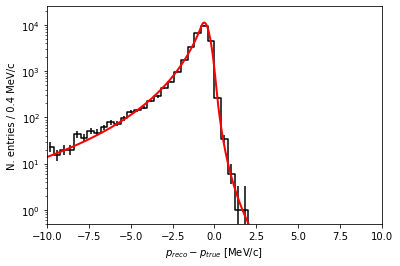

In [18]:
n_bins = 50
range_ = (-10,10)

data_hist, res_bins = np.histogram(data_res, bins=n_bins, range=range_)
bin_c, bin_w = bin_centers(res_bins)
_ = plt.errorbar(bin_c, data_hist, yerr=poisson_err(data_hist), fmt='none', color='k')
_ = plt.step(bin_c, data_hist, color='k', where='mid')

x = np.linspace(*range_, num=10000)
with dscb.set_norm_range(range_):
    pdf = zfit.run(dscb.pdf(x))
    
_ = plt.plot(x, data_res.shape[0] / n_bins * (range_[1] - range_[0]) * pdf, lw=2, color='r')

plt.yscale('log')
plt.xlabel(r"$p_{reco}-p_{true}$ [MeV/c]")
plt.ylabel(r"N. entries / %g MeV/c" % bin_w)

plt.ylim(bottom=0.5)
plt.xlim(range_)


In [19]:
mu.floating = False
sigma.floating = False
alphal.floating = False
alphar.floating = False
nr.floating = False
nl.floating = False

In [20]:
cuts = [
    "de_status > 0",
    "de_t0 > 700",
    "de_t0 < 1695",
    "deent_td > 0.577350",
    "deent_td < 1.000",
    "deent_d0 < 105",
    "-deent_d0 < 80",
    "(deent_d0 + 2./deent_om) > 450",
    "(deent_d0 + 2./deent_om) < 680",
    "dequal_TrkQual > 0.8",
    "dequal_TrkPID > 0.95",
    "ue_status <= 0",
    "deent_mom > 93",
    "(bestcrv < 0 | ((-de_t0 + crvinfo__timeWindowStart_best) > 50 | (de_t0-crvinfo__timeWindowStart_best) > 150.0))",
#     "is_triggered"
]

cut = " & ".join(cuts)

In [21]:
file_eminus = uproot.open("/Users/soleti/trkana-flateminus-mix-cat.MDC2018h.root")
eminus = file_eminus["TrkAnaNeg"]["trkana"]
n = 1000000
factor = n/3411450
df_eminus = eminus.pandas.df(flatname=default_flatname, flatten=False, entrystop=n)
df_eminus["demcgen_mom"] = np.sqrt(df_eminus["demcgen_momx"]**2+df_eminus["demcgen_momy"]**2+df_eminus["demcgen_momz"]**2)
df_eminus["is_triggered"] = (df_eminus["trigbits"].values & 0x208) > 0
df_eminus["crvinfo__timeWindowStart_best"] = [twstart[index] if index>=0 else 0 for index, twstart in zip(df_eminus["bestcrv"], df_eminus["crvinfo__timeWindowStart"])]
df_eminus["res"] = df_eminus["deent_mom"] - np.sqrt(df_eminus["demc_omomx"]**2+df_eminus["demc_omomy"]**2+df_eminus["demc_omomz"]**2)
df_eminus = df_eminus.query(cut)

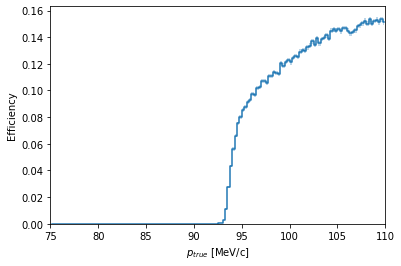

In [22]:
n_bins = 140
range_ = (75,110)
total_electrons = file_eminus["genCountLogger"]["numEvents"].values[0]*factor
n_cuts, eff_bins = np.histogram(df_eminus["demcgen_mom"], range=range_, bins=n_bins)
efficiency = n_cuts/(total_electrons/n_bins)
efficiency_err = 1/(total_electrons/n_bins)*np.sqrt(n_cuts*(1-n_cuts/(total_electrons/n_bins)))

plt.step(bin_centers(eff_bins)[0], efficiency, where='mid')
plt.fill_between(bin_centers(eff_bins)[0], efficiency-efficiency_err, efficiency+efficiency_err, alpha=0.3, step='mid')

plt.xlim(range_)
plt.ylim(bottom=0)
plt.xlabel("$p_{true}$ [MeV/c]")
plt.ylabel("Efficiency")

efficiency = np.insert(efficiency, 0, 0, axis=0)
efficiency = np.insert(efficiency, len(efficiency), 0, axis=0)

In [23]:
obs_spectrum = zfit.Space('x', limits=(93,110))
zfit.settings.options['numerical_grad'] = True

class BinnedEfficiencyFunc(zfit.func.ZFunc):
    _PARAMS = []

    def __init__(self, efficiency, eff_bins, obs, name='BinnedEfficiencyFunc'):
        self.efficiency = efficiency
        self.eff_bins = eff_bins
        super().__init__(obs=obs, name=name)
        
    def _binContent(self, x):
        eff_bin = np.digitize(x, self.eff_bins)
        return self.efficiency[eff_bin]
   
    def _func(self, x):
        x = zfit.ztf.unstack_x(x)
        probs = z.py_function(func=self._binContent, inp=[x], Tout=tf.float64)
        probs.set_shape(x.shape)
        return probs

In [24]:
muon = Particle.from_pdgid(13)
proton = Particle.from_pdgid(2212)
electron = Particle.from_pdgid(11)

bound_energy = Al.atomic_number**2 * alpha**2 * muon.mass / 2
recoil_energy = muon.mass**2/(2 * Al.mass * proton.mass)
eMax = muon.mass - bound_energy - recoil_energy


class CESpectrumPDF(zfit.pdf.ZPDF):
    _PARAMS = []  # the name of the parameters

    def _unnormalized_pdf(self, x): 
        x = zfit.ztf.unstack_x(x)
        
        me = zfit.ztf.constant(electron.mass)
        eMax = zfit.ztf.constant(muon.mass - bound_energy - recoil_energy)
        alpha_c = zfit.ztf.constant(alpha)
        pi_c = zfit.ztf.constant(pi)
        
        E = zfit.ztf.sqrt(x * x + me * me)
        result = (1. / eMax) * (alpha_c / (2 * pi_c)) * (zfit.ztf.log(4 * E * E / me / me) - 2.) * ((E * E + eMax * eMax) / eMax / (eMax - E))
        
        return tf.maximum(result, tf.zeros_like(result))
    
    
class DIOSpectrumPDF(zfit.pdf.ZPDF):
    _PARAMS = []
    
    def _unnormalized_pdf(self, x):
        # NLO PDF from https://mu2e-docdb.fnal.gov/cgi-bin/private/RetrieveFile?docid=6309&filename=formu2e.pdf&version=1
        x = z.unstack_x(x)
        
        c5 = z.constant(8.9e-17)
        c6 = z.constant(1.17169e-17)
        c7 = z.constant(-1.06599e-19)
        c8 = z.constant(8.14251e-20)
        
        me = z.constant(electron.mass)
        eMax = z.constant(muon.mass - bound_energy - recoil_energy)

        x = z.sqrt(x * x + me * me)
        deltax = eMax - x
    
        f = 2*z.log(muon.mass/electron.mass * (1-deltax/muon.mass)) - 2 + 2*log(2)
        expo = alpha/pi*f

        const = z.pow(deltax/muon.mass, expo)

        result = const * (c5 * deltax**5 + c6 * deltax**6 + c7 * deltax**7 + c8 * deltax**8)
        
        muon_energy = muon.mass - bound_energy
        end_point = z.constant(muon_energy - recoil_energy)
        
        cond = tf.less(x, end_point)        
        func = tf.where(cond,
                        result,
                        tf.zeros_like(result))
        
        probs = tf.maximum(func, tf.zeros_like(func))
        probs.set_shape(x.shape)
        
        return probs
    

In [25]:
efficiencyFunc = BinnedEfficiencyFunc(efficiency, eff_bins, obs_spectrum)
efficiencyPDF = efficiencyFunc.as_pdf()
efficiencyPDF.set_norm_range(obs_spectrum)

ce = CESpectrumPDF(obs=obs_spectrum)
dio = DIOSpectrumPDF(obs=obs_spectrum)

dio_eff = dio*efficiencyPDF
ce_eff = ce*efficiencyPDF

ce_convoluted = zphys.unstable.pdf.NumConvPDFUnbinnedV1(obs=obs_spectrum, func=ce_eff, kernel=dscb, limits=obs_spectrum, ndraws=1000)
dio_convoluted = zphys.unstable.pdf.NumConvPDFUnbinnedV1(obs=obs_spectrum, func=dio_eff, kernel=dscb, limits=obs_spectrum, ndraws=1000)

ce_convoluted._set_yield(yieldCE)
dio_convoluted._set_yield(yieldDIO)

dio_convoluted.set_norm_range(obs_spectrum)
ce_convoluted.set_norm_range(obs_spectrum)

spectrum = zfit.pdf.SumPDF(obs=obs_spectrum, pdfs=[ce_convoluted, dio_convoluted])
spectrum.set_norm_range(obs_spectrum)

In [26]:
dfs = []

true_ces = []
true_ces_cuts = []
true_dios = []
true_dios_reco = []
true_dios_cuts = []

data_zfit = []

run_files = ["root_files/trkana-ensemble-run5i-MC.root",
             "root_files/trkana-ensemble-run7i-MC.root"]

start=95

for file_name in run_files:
    file = uproot.open(file_name)
    trkananeg = file["TrkAnaNeg"]["trkana"]

    df = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
    df["is_triggered"] = (df["trigbits"].values & 0x208) > 0
    df["crvinfo__timeWindowStart_best"] = [twstart[index] 
                                           if index>=0 else 0
                                           for index, twstart in zip(df["bestcrv"], df["crvinfo__timeWindowStart"])]
    df["demcgen_mom"] = np.sqrt(df["demcgen_momx"]**2+df["demcgen_momy"]**2+df["demcgen_momz"]**2)

    true_dios.append(len(df.query("demcgen_gen == 7 & demcgen_mom >= %g" % start)))
    true_ces.append(len(df.query("demcgen_gen == 43 & demcgen_mom >= %g" % start)))
    df_cuts = df.query(cut)
    true_dios_reco.append(len(df.query("demcgen_gen == 7 & demcgen_mom >= %g & deent_mom >= %g" % (start,start))))
    dfs.append(df_cuts)
    true_ce_cuts = len(df_cuts.query("demcgen_gen == 43 & demcgen_mom >= %g & deent_mom >= %g" % (start,start)))
    if true_ce_cuts:
        true_ces_cuts.append(true_ce_cuts)
        true_dios_cuts.append(len(df_cuts.query("demcgen_gen == 7 & demcgen_mom >= %g & deent_mom >= %g" % (start,start))))

    data_zfit.append(zfit.data.Data.from_numpy(obs=obs_spectrum, array=df_cuts["deent_mom"].to_numpy()))


In [27]:
minimizer = zfit.minimize.Minuit(verbosity=8, use_minuit_grad=True)

def fit(data):
    nll = zfit.loss.ExtendedUnbinnedNLL(model=spectrum, data=data)  # loss
    minimum = minimizer.minimize(loss=nll)
    params = minimum.params    
    errors = minimum.hesse()
    
    return params, errors


params_errors = []

for data in data_zfit:
    params_errors.append(fit(data))


VariableMetric: start iterating until Edm is < 0.001
VariableMetric: Initial state   - FCN =  -71169.03831116 Edm =      2131.29 NCalls =      9
VariableMetric: Iteration #   0 - FCN =  -71169.03831116 Edm =      2131.29 NCalls =      9
VariableMetric: Iteration #   1 - FCN =  -73737.19315153 Edm =      8.73706 NCalls =     20
VariableMetric: Iteration #   2 - FCN =  -73741.38113088 Edm =     0.898303 NCalls =     26
VariableMetric: Iteration #   3 - FCN =   -73742.3478224 Edm =   0.00320774 NCalls =     32
VariableMetric: Iteration #   4 - FCN =  -73742.35168339 Edm =  3.41434e-06 NCalls =     38
VariableMetric: After Hessian   - FCN =  -73742.35168339 Edm =  1.60109e-06 NCalls =     52
VariableMetric: Iteration #   5 - FCN =  -73742.35168339 Edm =  1.60109e-06 NCalls =     52
------------------------------------------------------------------
| FCN = -7.374E+04              |      Ncalls=52 (52 total)      |
| EDM = 1.6E-06 (Goal: 5E-05)   |            up = 0.5            |
----------

In [28]:
yieldCE.set_value(params_errors[0][0][yieldCE]['value'])
print(spectrum.fracs[0].value())
yieldCE.set_value(params_errors[1][0][yieldCE]['value'])
print(spectrum.fracs[0].value())


tf.Tensor(0.0010211011227776422, shape=(), dtype=float64)
tf.Tensor(0.00586475289366841, shape=(), dtype=float64)


In [29]:
def ratio_err(num, den, num_err, den_err):
    n, d, n_e, d_e = num, den, num_err, den_err
    return np.abs(n/d) * np.sqrt((n_e/n)**2+(d_e/d)**2)


def residual_err(data, fit, data_err):
    # From https://cds.cern.ch/record/2217625/files/final.pdf 
    err = data_err[1]
#     err[data>=fit] = data_err[0][data>=fit]
    return err

def drawing_values(i):
    df = dfs[i]
    n_bins = 68
    range_ = obs_spectrum.limits[0][0][0], obs_spectrum.limits[1][0][0]
    binning = (range_[1]-range_[0])/n_bins

    data_hist, bins = np.histogram(
                          df['deent_mom'],
                          bins=n_bins,
                          range=range_)

    data_err = np.nan_to_num(poisson_err(data_hist))
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    bin_centers = np.array([b+bin_w/2. for b in bins[:-1]])

    plot_scaling = len(df.query("deent_mom>%g" % range_[0]) ) / n_bins * obs_spectrum.area()

    yieldCE.set_value(params_errors[i][0][yieldCE]['value'])
    yieldDIO.set_value(params_errors[i][0][yieldDIO]['value'])

    frac = spectrum.fracs[0].value()
    x = bin_centers
    y = spectrum.pdf(x).numpy()  
    y_ce = (ce_convoluted.pdf(x) * frac).numpy()
    y_dio = (dio_convoluted.pdf(x) * (1 - frac)).numpy()

    data_hist_err = np.nan_to_num(poisson_err(data_hist))
    
    return bin_centers, frac, data_hist, data_hist_err, x, y*plot_scaling, y_ce*plot_scaling, y_dio*plot_scaling, plot_scaling

def residuals(data_hist, dat_hist_err, y):
    res = data_hist-y
    res_err = residual_err(data_hist, y, data_hist_err)
    
    return res, res_err


In [30]:
def y_err(params_error, frac, plot_scaling):
    yieldCE_value = params_error[0][yieldCE]['value']
    yieldDIO_value = params_error[0][yieldDIO]['value']

    y_ce_err = (ce_convoluted.pdf(x)*params_error[1][yieldCE]['error']/yieldCE_value*frac).numpy()
    y_dio_err = (dio_convoluted.pdf(x)*params_error[1][yieldDIO]['error']/yieldDIO_value*(1-frac)).numpy()

    y_err = (y_ce_err+y_dio_err) * plot_scaling

    yieldCE.set_value(yieldCE_value)
    yieldDIO.set_value(yieldDIO_value)
    
    return y_err

In [31]:
def draw_plot(ax1, ax2, bin_centers, data_hist, data_hist_err, y, y_dio, y_ce, y_err, res, res_err):
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [2.5, 1]}, figsize=(9,7))
    ax1.errorbar(bin_centers, data_hist, yerr=data_hist_err, fmt='o', color='k')
    
    x = bin_centers
    y = np.hstack(y.numpy())
    y_err = np.hstack(y_err.numpy())
    
    redchi = scipy.stats.chisquare(data_hist[bin_centers>=95], y[bin_centers>=95]).statistic / (len(data_hist)-1)

    ax1.plot(x, y, label='Combined fit\n$\chi^2$ / n.d.f. = %.2f' % redchi, lw=2, color='r')
    ax1.plot(x, y_dio, label='DIO component', linestyle='--')
    ax1.plot(x, y_ce, label='CE component', linestyle='--')
    ax1.fill_between(x, (y-2*y_err), (y+2*y_err), color='yellow')
    ax1.fill_between(x, (y-y_err), (y+y_err), color='lawngreen')

    ax1.set_yscale('log')
    ax1.set_ylim(bottom=0.5)
    ax1.legend(frameon=False)
    ax1.set_xlim(95,110)
    ax1.set_xticklabels([])
    
    ax2.set_xlabel(r"Reco. momentum [MeV/$c$]", fontsize=12)
    ax1.set_ylabel(r"N. entries / 0.25 MeV/$c$", fontsize=12)
    ax2.errorbar(bin_centers, res/res_err, fmt='o',color='k', yerr=ratio_err(res, res_err, data_hist_err+y_err, 0))
    ax2.fill_between(x, 2*y_err/res_err, -2*y_err /res_err, color='yellow')
    ax2.fill_between(x, y_err/res_err, -y_err/res_err, color='lawngreen')

    ax2.hlines(linestyle='--', xmin=95, xmax=110, y=0)
    ax2.set_ylim(-3.5,3.5)
    ax2.set_xlim(95,110)

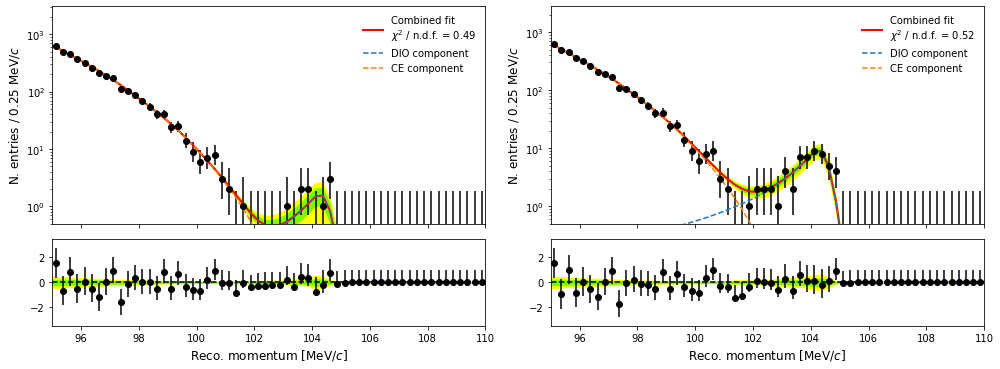

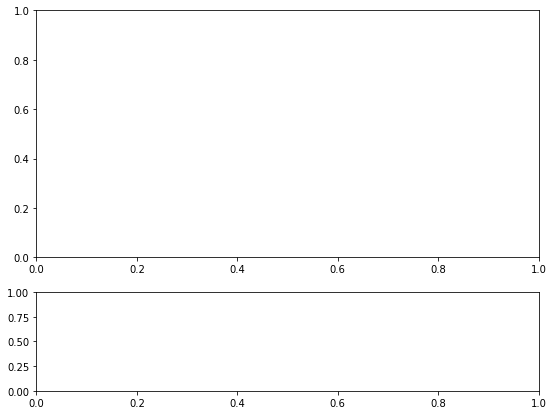

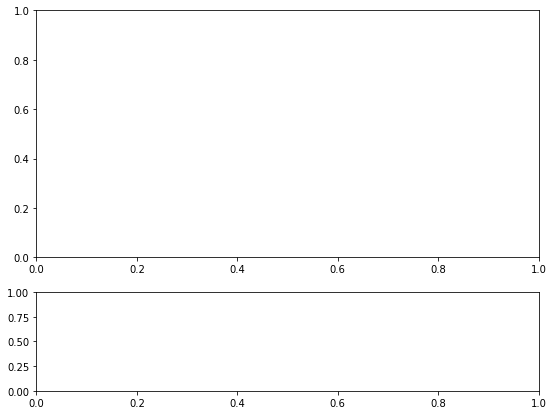

In [32]:
fit_results = []
fig = plt.figure(figsize=(14,20))

gs = gridspec.GridSpec(4,2)

i = 0
for row in range(4):
    for column in range(2):
        if i < 2:
            gs0 = gs[row,column].subgridspec(2, 1, height_ratios=[2.5,1], hspace=0.1)
            ax1 = fig.add_subplot(gs0[0])
            ax2 = fig.add_subplot(gs0[1])
            bin_centers, frac, data_hist, data_hist_err, x, y, y_ce, y_dio, plot_scaling = drawing_values(i)
            res, res_err = residuals(data_hist, data_hist_err, np.hstack(y.numpy()))
            y_err_value = y_err(params_errors[i], frac, plot_scaling)
            draw_plot(ax1, ax2, bin_centers, data_hist, data_hist_err, y, y_ce, y_dio, y_err_value, res, res_err)
        i+=1
            
fig.tight_layout()
fig.savefig("plots/spectra.pdf")